# COMP0123 Complex Networks and Webs Coursework 1

Importing libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from sympy import symbols, Eq, solve
from matplotlib.ticker import FuncFormatter
from collections import Counter
from scipy.stats import linregress

In [2]:
seed = 42
random.seed(seed)

## Task 0 - Preparation of Network Data

### Creating our Author Network

- Among the millions of authors, firstly you extract all authors whose research interests are related to 'social network', including those with interests in 'Social network', 'social networks', 'human social network' etc.

In [3]:
# Creating our graph
G = nx.Graph()

In [4]:
# Retrieving indices of all author's who have an interest in 'social networks'
author_indices = []
interest = "social network"

with open("data/AMiner-Author.txt", 'r', encoding='utf-8') as f:
    current_author_index = 1
    for line in f:
        if line.startswith("#t"):
            interests = line[2:]
            # Check if any variant of the interest is in the author's interests.
            if interest in interests.lower():
                author_indices.append(current_author_index)
            current_author_index += 1

In [5]:
# Adding all author indices to the graph
G.clear()
G.add_nodes_from(author_indices)
G.number_of_nodes()

9219

- Secondly, you extract all links (co-authorships) among the above authors. You should discard any authors with degree 0 (that have no link with any of the other authors) and any repeated links, so that you create a simple graph.

In [6]:
# Adding in edges
edges = []
author_indices = set(author_indices)

with open("data/AMiner-Coauthor.txt", 'r') as f:
    for line in f:
        author1, author2, _ = line.split()
        author1 = int(author1[1:])
        author2 = int(author2)
        
        if (author1 in author_indices) and (author2 in author_indices):
            edges.append([author1, author2])
        

In [7]:
G.add_edges_from(edges)
G.number_of_edges()

12129

- Thirdly, you extract the giant component in the above simple graph. For your information, the giant component should contain 2,068 unique nodes and 5,163 unique links. Note that link a-b is same as link b-a, which is a single unique link, not two links.

In [8]:
# Achieving giant component
author_network = G.subgraph(max(nx.connected_components(G), key=len))

In [9]:
# Desired Values
n_count = 2068
e_count = 5163

In [10]:
assert nx.is_connected(author_network)
assert n_count == author_network.number_of_nodes()
assert e_count == author_network.number_of_edges()

In [11]:
# # Plotting Author Network
# plt.figure(figsize=(5,5))
# pos = nx.spring_layout(author_network, seed= seed)
# nx.draw(author_network, node_size= 2, width= 1, pos= pos)

### Generating Random Network

We generate a random tree with $n$ nodes which ensures the graph is connected and has $n-1$ edges. We then randomly add the remaining $e - (n-1)$ edges

In [14]:
def create_random_connected_graph(n, e):
    G = nx.gnm_random_graph(n, e, seed= seed)
    
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        while len(components) > 1:
            components = sorted(components, key=len, reverse=True)
            
            # Connect two nodes from different components
            u = random.choice(list(components[0]))
            v = random.choice(list(components[1]))
            G.add_edge(u, v)
            
            # Remove a random edge from the larger component
            u_prime, v_prime = random.choice(list(G.edges(components[0])))
            G.remove_edge(u_prime, v_prime)
            
            components = list(nx.connected_components(G))

    return G

In [15]:
random_network = create_random_connected_graph(n_count, e_count)

In [16]:
# Ensuring necessary network properties
assert nx.is_connected(random_network)
assert random_network.number_of_edges() == e_count
assert random_network.number_of_nodes() == n_count

### Generating BA Network

In [17]:
# Creating our initial random graph
initial = create_random_connected_graph(20, 30)

$E = m_1(N_1-N_{initial}) + E_{initial} + m_2(N - N_1)$

$5163 = m_1(N_1-20) + 30 + m_2(2068 - N_1)$

In [18]:
# # Defining the symbols
# N1, m1, m2 = symbols('N1 m1 m2', integer=True)

# initial_nodes = initial.number_of_nodes()
# initial_edges = initial.number_of_edges()

# # Equation
# equation = Eq(e_count, m1*(N1 - initial_nodes) + initial_edges + m2*(n_count - N1))

# # Set up a list to store potential solutions
# solutions = []

# # Iterate through possible values for m1 and m2
# for m1_value in range(2, 10):  # Adjust range as necessary
#     for m2_value in range(2, 10):  # Adjust range as necessary
#         # Solve the equation for N1 with current values of m1 and m2
#         N1_solutions = solve(equation.subs({m1: m1_value, m2: m2_value}), N1)
        
#         # Filter solutions to only include positive integers and where N1 is within bounds
#         for sol in N1_solutions:
#             if sol.is_integer and sol > 0 and sol < n_count:
#                 # Check if it's a valid solution by ensuring that m1 and m2 will also be positive integers
#                 remaining_edges = e_count - initial_edges
#                 edges_for_m1 = m1_value * (sol - initial_nodes)
#                 edges_for_m2 = m2_value * (n_count - sol)
#                 if 0 <= edges_for_m1 <= remaining_edges and 0 <= edges_for_m2 <= remaining_edges:
#                     solutions.append((m1_value, m2_value, sol))

# # m1, m2, N1
# solutions


$5163 = 2(1057-20) + 30 + 3(2068 - 1057)$

In [19]:
BA = nx.barabasi_albert_graph(1057, 3, initial_graph= initial, seed= seed)
BA = nx.barabasi_albert_graph(2068, 2, initial_graph= BA, seed= seed)

In [20]:
# Ensuring necessary network properties
assert nx.is_connected(BA)
assert BA.number_of_edges() == e_count
assert BA.number_of_nodes() == n_count

## Task 1

- Calculate the average node degree and the maximum node degree of the 3 networks

$ \bar{k} \equiv \frac{1}{N} \sum^{N}_{i = 1} k_i = \frac{2E}{N}$

In [19]:
round(2 * e_count / n_count, 2)

4.99

In [68]:
"Author Network Max Degree: " + str(max(dict(author_network.degree()).values()))

'Author Network Max Degree: 51'

In [69]:
"Random Graph Max Degree: " + str(max(dict(random_network.degree()).values()))

'Random Graph Max Degree: 13'

In [70]:
"BA Graph Max Degree: " + str(max(dict(BA.degree()).values()))

'BA Graph Max Degree: 96'

- Plot their degree distribution $P(k)$ on linear-linear scale and log-log scale,
respectively

$ P(k) = \frac{N_k}{N}$

In [32]:
def plot_degree_distribution(graphs, graph_names, image_name):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']
    
    # Linear scale plot
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)  # first subplot
    plt.title("Linear-Linear Scale")
    plt.xlabel("Degree $k$")
    plt.ylabel("Probability $P(X=k)$")

    for i, G in enumerate(graphs):
        N_k = nx.degree_histogram(G)[1:]
        pk = [i/sum(N_k) for i in N_k]  # normalized so they sum to 1
        k = list(range(1, len(N_k) + 1))
        plt.scatter(k, pk, edgecolors=colors[i], label=graph_names[i], marker=markers[i], facecolors='none')

    
    plt.legend(loc='upper right')
    
    # Log-log scale plot
    plt.subplot(1, 2, 2)  # second subplot
    plt.title("Log-Log Scale")
    plt.xlabel("Degree $k$")
    plt.ylabel("Probability $P(X=k)$")

    for i, G in enumerate(graphs):
        N_k = nx.degree_histogram(G)
        k = np.array(range(len(N_k)))
        pk = np.array([i/sum(N_k) for i in N_k])

        # Remove zero values to avoid log(0) errors
        mask = (k > 0) & (pk > 0)
        k = k[mask]
        pk = pk[mask]

        # Fit log-log data with a cubic polynomial
        log_k = np.log(k)
        log_pk = np.log(pk)
        coefficients = np.polyfit(log_k, log_pk, 4)
        poly = np.poly1d(coefficients)
        y_fit = np.exp(poly(np.log(k)))
        plt.loglog(k, y_fit, color=colors[i])  # best fit curve
        plt.loglog(k, pk, marker=markers[i], label=graph_names[i], 
                   markersize = 5, markerfacecolor="None",
                   markeredgecolor= colors[i], color= colors[i], linestyle= '',
                   linewidth= 0.6)

    plt.tight_layout()
    plt.legend()
    plt.savefig("images/" + image_name + ".png", dpi=300)

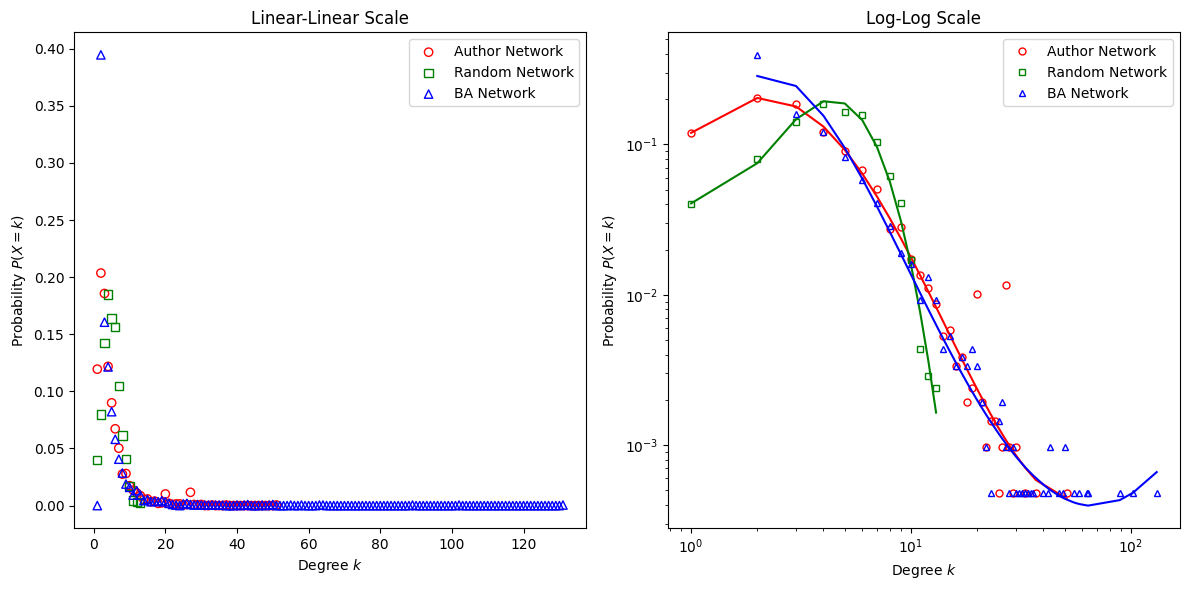

In [33]:
plot_degree_distribution([author_network, random_network, BA], ['Author Network', 'Random Network', 'BA Network'], "degree_distributions")

In [34]:
def plot_degree_distribution_linear(graphs, graph_names, image_name):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']
    
    # Linear scale plot
    plt.figure(figsize=(12,6))
    plt.title("Linear-Linear Scale")
    plt.xlabel("Degree $k$")
    plt.ylabel("Probability $P(X=k)$")

    for i, G in enumerate(graphs):
        N_k = nx.degree_histogram(G)[1:]
        pk = [i/sum(N_k) for i in N_k]  # normalized so they sum to 1
        k = list(range(1, len(N_k) + 1))
        plt.scatter(k, pk, edgecolors=colors[i], label=graph_names[i], marker=markers[i], facecolors='none')

    
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.legend()
    plt.show()
    # plt.savefig("images/" + image_name + ".png", dpi=300)

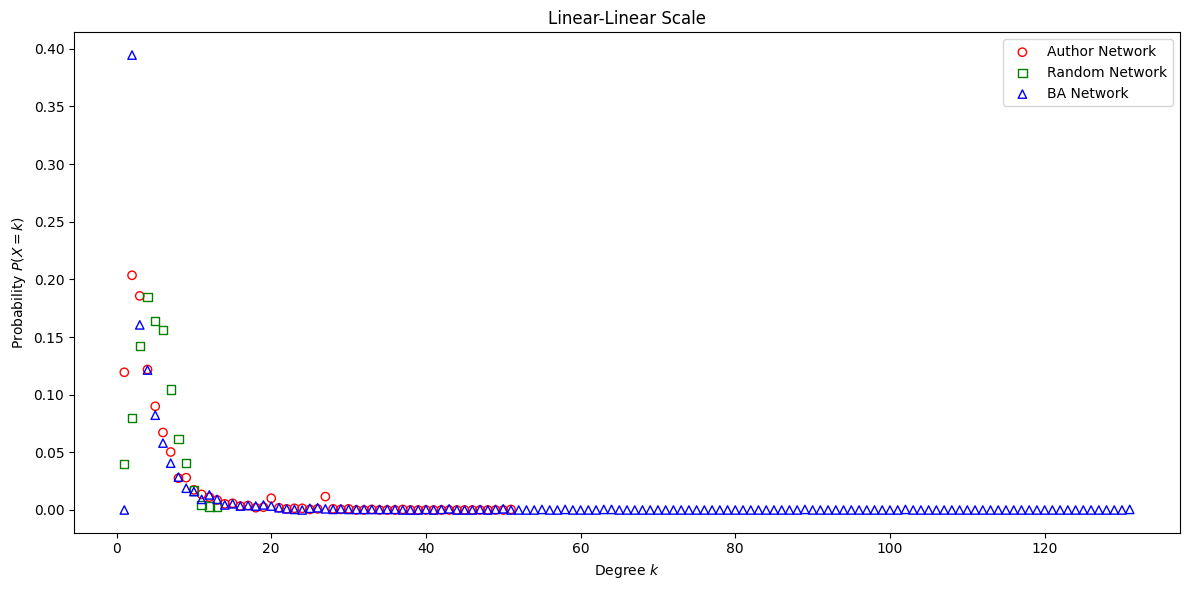

In [35]:
plot_degree_distribution_linear([author_network, random_network, BA], ['Author Network', 'Random Network', 'BA Network'], "degree_distributions_linear")

In [36]:
def plot_degree_distribution_log(graphs, graph_names, image_name):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']
    
    # Log-log scale plot
    plt.figure(figsize=(12,6))
    plt.title("Log-Log Scale")
    plt.xlabel("Degree $k$")
    plt.ylabel("Probability $P(X=k)$")

    for i, G in enumerate(graphs):
        N_k = nx.degree_histogram(G)
        k = np.array(range(len(N_k)))
        pk = np.array([i/sum(N_k) for i in N_k])

        # Remove zero values to avoid log(0) errors
        mask = (k > 0) & (pk > 0)
        k = k[mask]
        pk = pk[mask]

        # Fit log-log data with a cubic polynomial
        log_k = np.log(k)
        log_pk = np.log(pk)
        coefficients = np.polyfit(log_k, log_pk, 4)
        poly = np.poly1d(coefficients)
        y_fit = np.exp(poly(np.log(k)))
        plt.loglog(k, y_fit, color=colors[i])  # best fit curve
        plt.loglog(k, pk, marker=markers[i], label=graph_names[i], 
                   markersize = 5, markerfacecolor="None",
                   markeredgecolor= colors[i], color= colors[i], linestyle= '',
                   linewidth= 0.6)

    plt.tight_layout()
    plt.legend()
    plt.show()
    # plt.savefig("images/" + image_name + ".png", dpi=300)

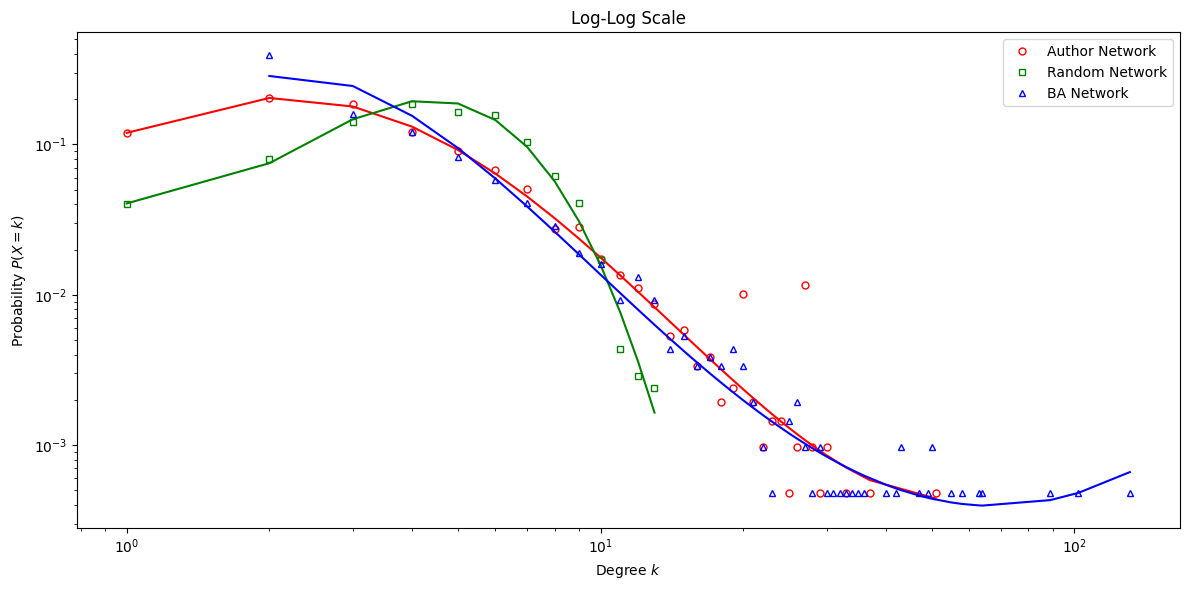

In [37]:
plot_degree_distribution_log([author_network, random_network, BA], ['Author Network', 'Random Network', 'BA Network'], "degree_distributions_log")

- Estimate the power-law exponent of the degree distribution P(k) of the author
network only.
  -  You can fit a curve by using the function polyfit from the numpy library.
  -  Ideally, you can do the fitting on CCDF (the complementary cumulative
distribution function) on log-log scale.

In [23]:
def plot_ccdf_with_power_law(graph, cutoff=None):
    # Calculate the degree of each node and get the degree sequence
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=False)
    n = len(degree_sequence)  # Number of nodes

    # Count the frequency of each degree in the sequence
    degree_counts = Counter(degree_sequence)
    
    # Calculate the CCDF
    ccdf_degrees = []
    ccdf_values = []
    for degree, count in sorted(degree_counts.items()):
        if degree == 0: 
            continue  # Skip the 0 degree to avoid log(0) issues.
        ccdf = sum(c for d, c in degree_counts.items() if d > degree) / n
        if ccdf > 0:  # Include only positive CCDF values
            ccdf_degrees.append(degree)
            ccdf_values.append(ccdf)

    ccdf_degrees_cut = None
    ccdf_values_cut = None

    # Apply cutoff if specified
    if cutoff is not None:
        cutoff_indices = [i for i, deg in enumerate(ccdf_degrees) if deg <= cutoff]
        ccdf_degrees_cut = np.array(ccdf_degrees)[cutoff_indices]
        ccdf_values_cut = np.array(ccdf_values)[cutoff_indices]

    ccdf_degrees = np.array(ccdf_degrees)
    ccdf_values = np.array(ccdf_values)
    
    ccdf_degrees1 = ccdf_degrees if cutoff is None else ccdf_degrees_cut
    ccdf_values1 = ccdf_values if cutoff is None else ccdf_values_cut

    # Perform linear regression on the log-log plot data above the cutoff
    log_degrees = np.log(ccdf_degrees1)
    log_ccdf = np.log(ccdf_values1)
    slope, intercept, r_value, p_value, std_err = linregress(log_degrees, log_ccdf)
    
    # Estimate the power-law exponent
    alpha = -slope + 1  # since the slope corresponds to -(alpha-1)
    
    # Plot the CCDF on a log-log scale
    plt.figure(figsize=(8, 6))
    plt.loglog(ccdf_degrees, ccdf_values, 'bo', markersize=4)
    
    # Plot the fitted line for the positive CCDF values above the cutoff
    plt.loglog(ccdf_degrees1, np.exp(intercept) * np.power(ccdf_degrees1, slope), 'r-', label=f'Fitted line with exponent {alpha:.2f}')
    
    # Plot enhancements
    plt.title("CCDF of Graph Degrees and Power-Law Fit")
    plt.xlabel("Degree, k (log scale)")
    plt.ylabel("P(X > k) (log scale)")
    plt.legend()
    plt.show()

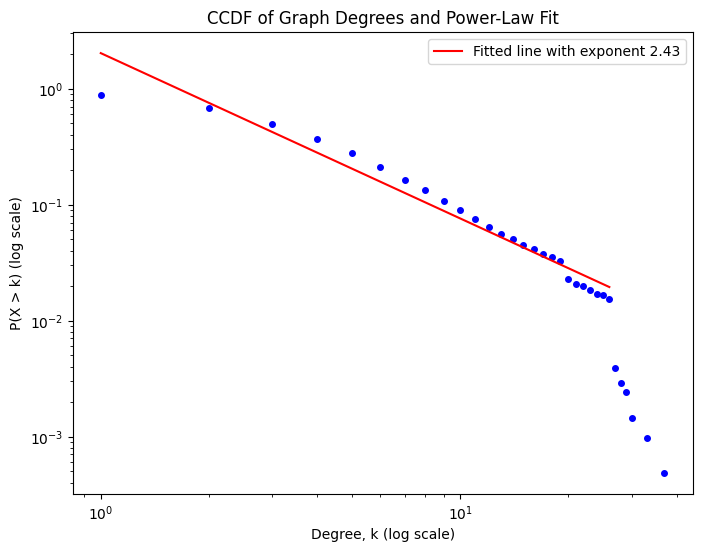

In [24]:
plot_ccdf_with_power_law(author_network, cutoff= 26)

## Task 2

- Calculate and plot the nearest neighbour’s average degree $knn$ as a function of
node degree $k$, on log-log scale.

In [36]:
def plot_knn(graphs, graph_names):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']
    
    plt.figure(figsize=(10,5))
    plt.xlabel("Node Degree " + r'$k$')
    plt.ylabel("Nearest Neighbour's Avg Degree " + r'$k_{nn}(k)$')
    
    for i, G in enumerate(graphs):
        knn = nx.average_degree_connectivity(G)
        k = list(knn.keys())
        values = list(knn.values())

        # Sorting the k-values and corresponding knn-values
        sorted_pairs = sorted(zip(k, values))
        k_sorted, values_sorted = zip(*sorted_pairs)

        plt.loglog(k_sorted, values_sorted, marker=markers[i], label=graph_names[i], 
                   markersize = 5, markerfacecolor="None",
                   markeredgecolor= colors[i], color= colors[i], linewidth= 0.6)
    
    plt.legend()
    plt.savefig('images/nearest_neighbours_average_degree.png', dpi= 300)

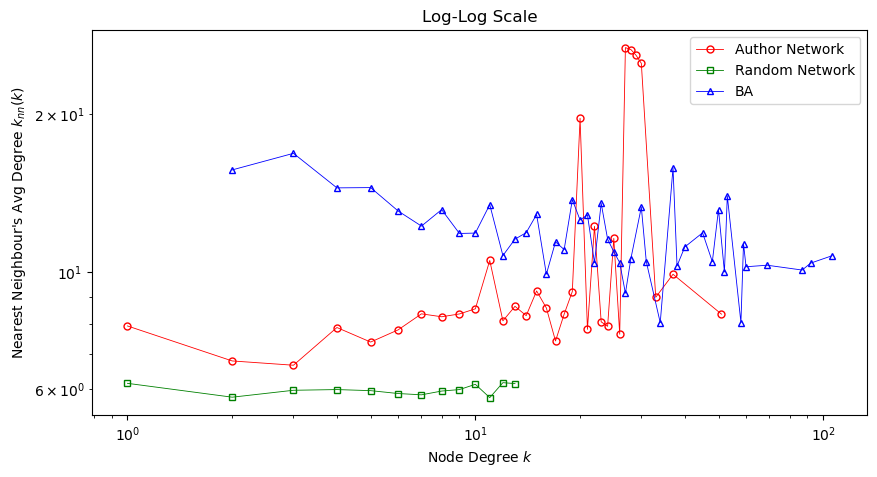

In [37]:
plot_knn([author_network, random_network, BA], ['Author Network', 'Random Network', 'BA'])

- Calculate the assortative coefficient of the networks

In [38]:
print(f"Author Network Associative Coefficient: ", round(nx.degree_assortativity_coefficient(author_network), 2))

Author Network Associative Coefficient:  0.47


In [42]:
print(f"Random Network Associative Coefficient: ", round(nx.degree_assortativity_coefficient(random_network), 2))

Random Network Associative Coefficient:  0.0


In [40]:
print(f"BA Network Associative Coefficient: ", round(nx.degree_assortativity_coefficient(BA), 2))

BA Network Associative Coefficient:  -0.06


## Task 3

- Calculate the diameter and the average shortest path length of the network.

In [ ]:
print("Author Network")
print("Diameter: " + str(nx.diameter(author_network)))
print("Average Shortest Path Length: " + str(round(nx.average_shortest_path_length(author_network), 2)))

In [ ]:
print("Random Network")
print("Diameter: " + str(nx.diameter(random_network)))
print("Average Shortest Path Length: " + str(round(nx.average_shortest_path_length(random_network), 2)))

In [ ]:
print("BA Network")
print("Diameter: " + str(nx.diameter(BA)))
print("Average Shortest Path Length: " + str(round(nx.average_shortest_path_length(BA), 2)))

In [ ]:
def average_betweenness_per_degree(G):
    # Calculate normalized betweenness centrality for all nodes
    betweenness = nx.betweenness_centrality(G, normalized=True, seed= seed)

    # Create a dictionary to hold sum of betweenness centrality and count for each degree k
    degree_dict = {}
    for node, k in G.degree():
        if k not in degree_dict:
            degree_dict[k] = {'sum': 0, 'count': 0}
        degree_dict[k]['sum'] += betweenness[node]
        degree_dict[k]['count'] += 1

    # Calculate average betweenness centrality for each degree k
    avg_betweenness = {k: v['sum'] / v['count'] for k, v in degree_dict.items()}

    return avg_betweenness

In [ ]:
def plot_avg_betweenness(graphs, graph_names):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']
    
    plt.figure(figsize=(8,5))
    plt.title("Log-Log Scale")
    plt.xlabel("Degree " + r'$k$')
    plt.ylabel("Average Node Betweenness")
    
    for i, G in enumerate(graphs):
        avg_betweenness = average_betweenness_per_degree(G)
        
        # Filtering out 0 values
        avg_betweenness = {k: v for k, v in avg_betweenness.items() if v > 0}

        # Sorting for coherent line plots
        sorted_pairs = sorted(avg_betweenness.items())
        degrees, betweenness_values = zip(*sorted_pairs)

        plt.loglog(degrees, betweenness_values, 
                   marker=markers[i], label=graph_names[i], 
                   markersize = 3, markerfacecolor="None",
                   markeredgecolor= colors[i], color= colors[i],
                   linewidth= 0.4)
    
    plt.legend()
    plt.savefig('images/average_node_betweenness.png', dpi= 300)


In [ ]:
plot_avg_betweenness([author_network, random_network, BA], ["Author Network", "Random Network", "BA Network",])

## Task 4

- Calculate and plot the rich-club coefficient as a function of node rank on log-log
scale.

In [55]:
from matplotlib import lines


def E(G, nodes):
    node_set = set(nodes)
    edges = 0
    for node in node_set:
        neighbors = set(G.neighbors(node))
        edges += len(neighbors.intersection(node_set))
    return edges // 2

def calc_rich_club_coeff(G, ranked_nodes, r):
    top_r_nodes = ranked_nodes[0 : r]
    E_r = E(G, top_r_nodes)
    return (2 * E_r) / (r * (r - 1))

def plot_rich_club(graphs, graph_names):
    colors = ["red", "green", "blue"]
    linestyles = ['-', '--', ':']
    markers = ['o', 's', '^']
    
    plt.figure(figsize=(12,6))

    def percent_formatter(x, pos):
        return f'{100*x:.2f}%'

    for i, G in enumerate(graphs):
        # Nodes are sorted by decreasing number of links that each node contains
        # [(Node, Degree), ...]
        degrees = G.degree()
        ranked_nodes = [node for node, _ in sorted(degrees, key=lambda x: x[1], reverse=True)]
        
        rcc = []
        for rank in range(2, G.number_of_nodes()):
           rcc.append(calc_rich_club_coeff(G, ranked_nodes, rank))
        
        total_nodes = G.number_of_nodes()
        percentage_ranks = [(r / total_nodes) for r in range(2, total_nodes)]

        # Filter out values where rcc is 0
        percentage_ranks, rcc = zip(*[(pr, r) for pr, r in zip(percentage_ranks, rcc) if r != 0])

        if graph_names[i] == 'BA Network':
            percentage_ranks = percentage_ranks[1:]
            rcc = rcc[1:]

        print(graph_names[i])
        print(percent_formatter(np.interp(0.01, percentage_ranks, rcc), None))

        plt.loglog(percentage_ranks, rcc, label=graph_names[i], 
                   color=colors[i], linestyle=linestyles[i], marker=markers[i], 
                   markersize=3, markerfacecolor='none', markeredgecolor= colors[i])

    plt.gca().xaxis.set_major_formatter(FuncFormatter(percent_formatter))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    plt.axvline(x=0.01, color='gray', linestyle='--')
    plt.xlim(left=0.001)  # start x-axis from 0.1%
    
    plt.title('$\phi(r)$ vs $r$')
    plt.xlabel('$r$')
    plt.ylabel('$\phi(r)$')
    plt.legend()
    plt.savefig('images/rich_club_against_node_rank.png', dpi=300)


Author Network
65.23%
Random Network
1.97%
BA Network
18.21%


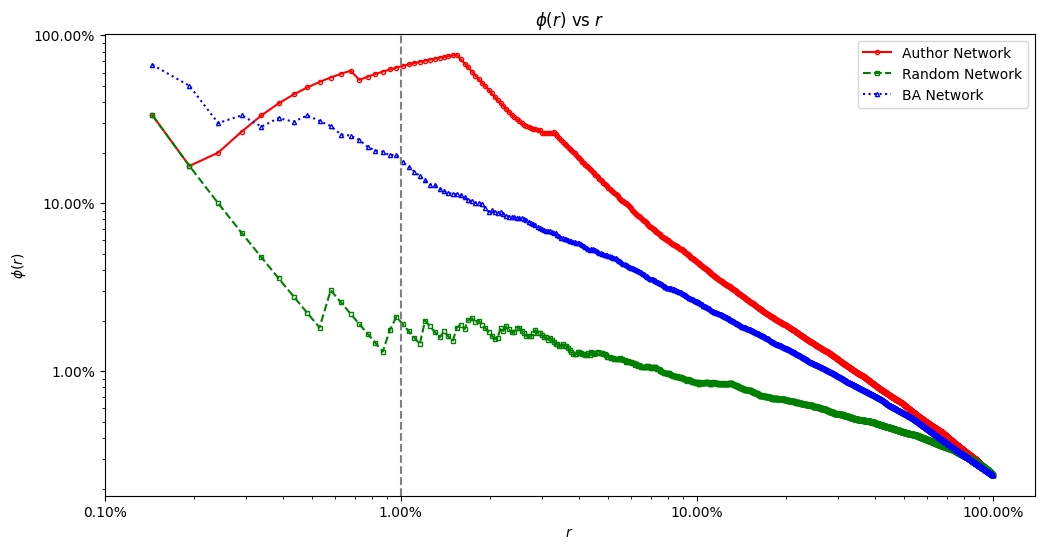

In [56]:
plot_rich_club([author_network, random_network, BA], ['Author Network', 'Random Network', 'BA Network'])

- Calculate and plot the rich-club coefficient as a function of node degree on log-log scale

In [ ]:
def plot_rich_club2(graphs, graph_names):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']

    plt.figure(figsize=(12,6))

    for i, G in enumerate(graphs):
        # Calculate the rich-club coefficient
        rich_club = nx.rich_club_coefficient(G, normalized=False, seed= seed)

        # Sort by degree for plotting
        degrees = [degree for degree in sorted(rich_club.keys()) if rich_club[degree] != 0]
        coefficients = [rich_club[degree] for degree in degrees if rich_club[degree] != 0]
        
        # By Node Degree
        plt.loglog(degrees, coefficients, color= colors[i],
                   marker=markers[i], label=graph_names[i], 
                   markersize = 4, markerfacecolor="None",
                   markeredgecolor= colors[i], linewidth= 0.6)

    plt.title('$\phi(k)$ vs $k$')
    plt.xlabel('Node Degree ' + r'$k$')
    plt.ylabel('Rich-Club Coefficient ' + r'$\phi (k)$')
    plt.legend()
    plt.savefig('images/rich_club_against_node_degree.png', dpi=300)

In [ ]:
plot_rich_club2([author_network, random_network, BA], ['Author Network', 'Random Network', 'BA Network'])

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def E(G, nodes):
    node_set = set(nodes)
    edges = 0
    for node in node_set:
        neighbors = set(G.neighbors(node))
        edges += len(neighbors.intersection(node_set))
    return edges // 2

def calc_rich_club_coeff(G, ranked_nodes, r):
    top_r_nodes = ranked_nodes[0 : r]
    E_r = E(G, top_r_nodes)
    return (2 * E_r) / (r * (r - 1))

def combined_rich_club_plot(graphs, graph_names):
    colors = ["red", "green", "blue"]
    markers = ['o', 's', '^']

    plt.figure(figsize=(15,5))

    # First plot: Rich club based on rank
    plt.subplot(121)
    for i, G in enumerate(graphs):
        degrees = G.degree()
        ranked_nodes = [node for node, _ in sorted(degrees, key=lambda x: x[1], reverse=True)]
        
        rcc = []
        for rank in range(2, G.number_of_nodes()):
            rcc.append(calc_rich_club_coeff(G, ranked_nodes, rank))

        plt.loglog([r for r in range(2, G.number_of_nodes())], rcc,
                   marker=markers[i], label=graph_names[i], 
                   linestyle= '', markersize = 3, markerfacecolor="None",
                   markeredgecolor= colors[i])

    plt.title('Log-Log Scale')
    plt.xlabel('Node Rank $r$')
    plt.ylabel('Rich-Club Coefficient $\phi(r)$')
    plt.legend()

    # Second plot: Rich club based on degree
    plt.subplot(122)
    for i, G in enumerate(graphs):
        rich_club = nx.rich_club_coefficient(G, normalized=False, seed=seed)
        degrees = [degree for degree in sorted(rich_club.keys()) if rich_club[degree] != 0]
        coefficients = [rich_club[degree] for degree in degrees if rich_club[degree] != 0]

        plt.loglog(degrees, coefficients, color=colors[i],
                   marker=markers[i], label=graph_names[i], 
                   markersize=4, markerfacecolor="None",
                   markeredgecolor=colors[i], linewidth=0.6)

    plt.title('Log-Log Scale')
    plt.xlabel('Node Degree ' + r'$k$')
    plt.ylabel('Rich-Club Coefficient ' + r'$\phi (k)$')
    plt.legend()

    # Display the combined plot
    plt.tight_layout()
    plt.savefig('images/rich_club.png', dpi= 300)

# Now you can call the combined_rich_club_plot function to get both plots side by side.


In [ ]:
combined_rich_club_plot([author_network, random_network, BA], ['Author Network', 'Random Network', 'BA'])

## Task 5

- Obtain the community structure (with the largest modularity value) of the 3
networks.

- Give the number of communities and the size (i.e. number of nodes) of the top 3
largest communities in each network

- Visualise the network and show each community with a different colour.

In [20]:
def detect_communities(graph):
    """Detect communities using the Louvain method."""
    communities = nx.algorithms.community.louvain_communities(graph, seed= seed)
    return sorted(communities, key=len, reverse=True)

def display_community_info(graph_name, graph, communities):
    """Display information about the communities detected."""
    modularity_value = nx.community.modularity(graph, communities)
    print(graph_name)
    print(f"Modularity Value: {round(modularity_value, 2)}")
    print(f"Number of Communites: {len(communities)}")
    for i, size in enumerate([len(c) for c in communities[:3]], 1):
        print(f"No. {i} Largest Community Size: {size}")

def visualize_communities(graph, communities):
    """Visualize the detected communities."""
    pos = nx.spring_layout(graph, seed=seed)
    plt.figure(figsize=(10, 6))
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(graph, pos, community, node_size=3, node_color=f"C{i}")
    nx.draw_networkx_edges(graph, pos, alpha=0.5, width=0.3)
    plt.title("Community structure")
    # plt.savefig("graph.png", dpi=1000)
    plt.show()

Author Network
Modularity Value: 0.9
Number of Communites: 43
No. 1 Largest Community Size: 132
No. 2 Largest Community Size: 120
No. 3 Largest Community Size: 119


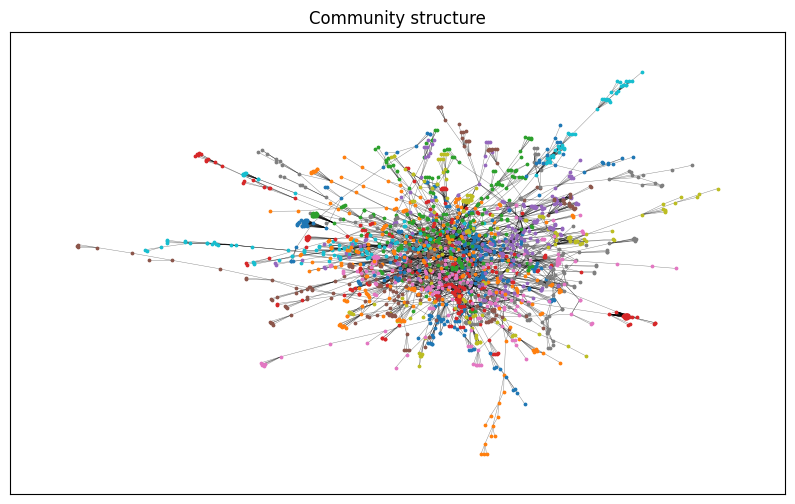

In [21]:
communities = detect_communities(author_network)
display_community_info("Author Network", author_network, communities)
visualize_communities(author_network, communities)

Random Network
Modularity Value: 0.45
Number of Communites: 22
No. 1 Largest Community Size: 152
No. 2 Largest Community Size: 144
No. 3 Largest Community Size: 139


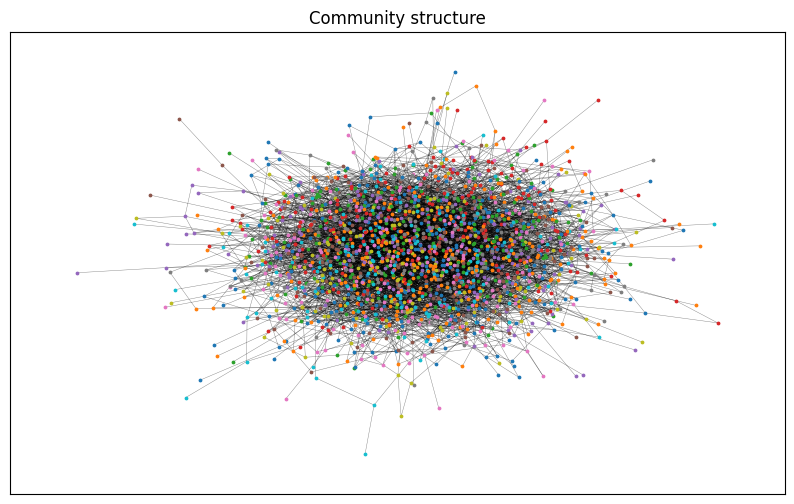

In [22]:
communities = detect_communities(random_network)
display_community_info("Random Network", random_network, communities)
visualize_communities(random_network, communities)

BA Network
Modularity Value: 0.45
Number of Communites: 22
No. 1 Largest Community Size: 191
No. 2 Largest Community Size: 185
No. 3 Largest Community Size: 169


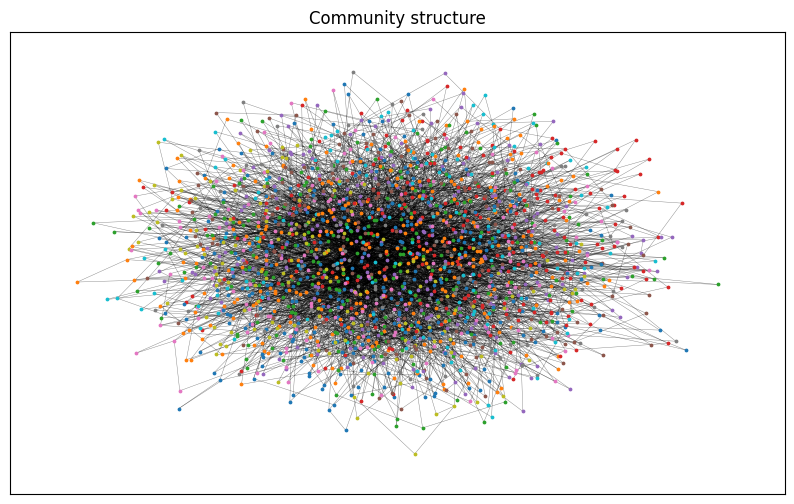

In [23]:
communities = detect_communities(BA)
display_community_info("BA Network", BA, communities)
visualize_communities(BA, communities)

## Task 6

- Randomly rewire the 3 networks while preserving the degree distribution; and 
obtain the maximal random case of each network.

*Structural constraints in complex networks Section 2.1 (Maximal Random Case 1)* randomly choose a pair of links and swap two of their end nodes. This is equivalent to reconnecting the four end nodes using a wiring pattern chosen at random. The process is repeated a sufficiently large number of times.

In [21]:
def rewire(G):
    G_rewired = nx.Graph.copy(G)
    nx.algorithms.double_edge_swap(G_rewired, nswap= e_count * 1000, max_tries= e_count * 10000, seed= seed)
    return G_rewired

In [22]:
author_network_rewired = rewire(author_network)
random_network_rewired = rewire(random_network)
BA_rewired = rewire(BA)

- For the 3 randomised networks, plot their degree distribution

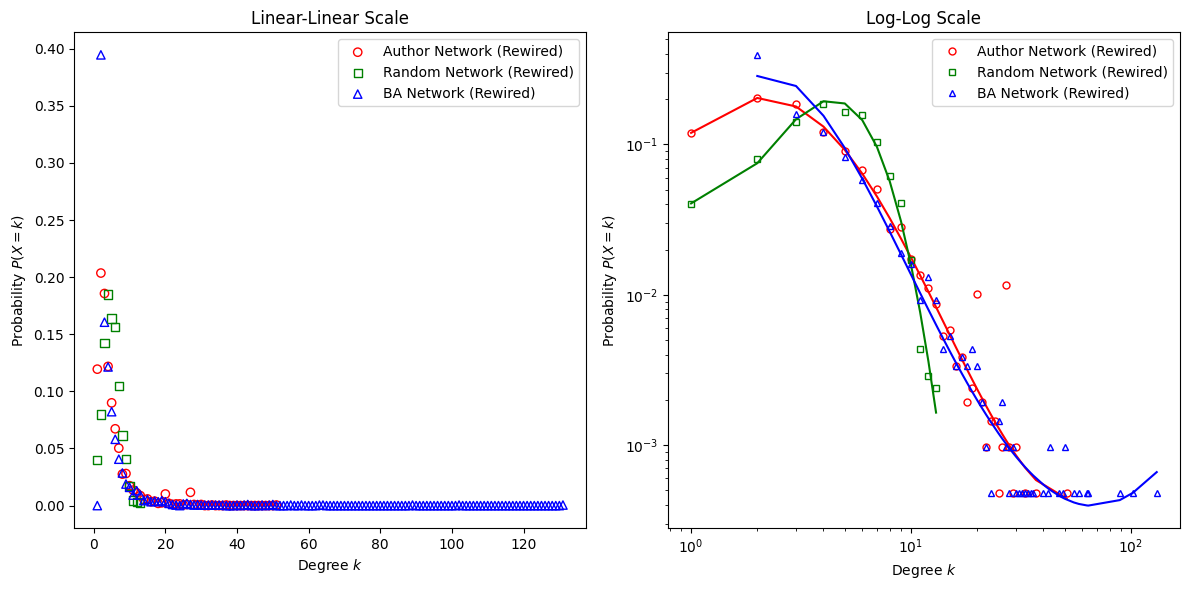

In [41]:
plot_degree_distribution([author_network_rewired, random_network_rewired, BA_rewired], ['Author Network (Rewired)', 'Random Network (Rewired)', 'BA Network (Rewired)'], "degree_distributions_rewired")

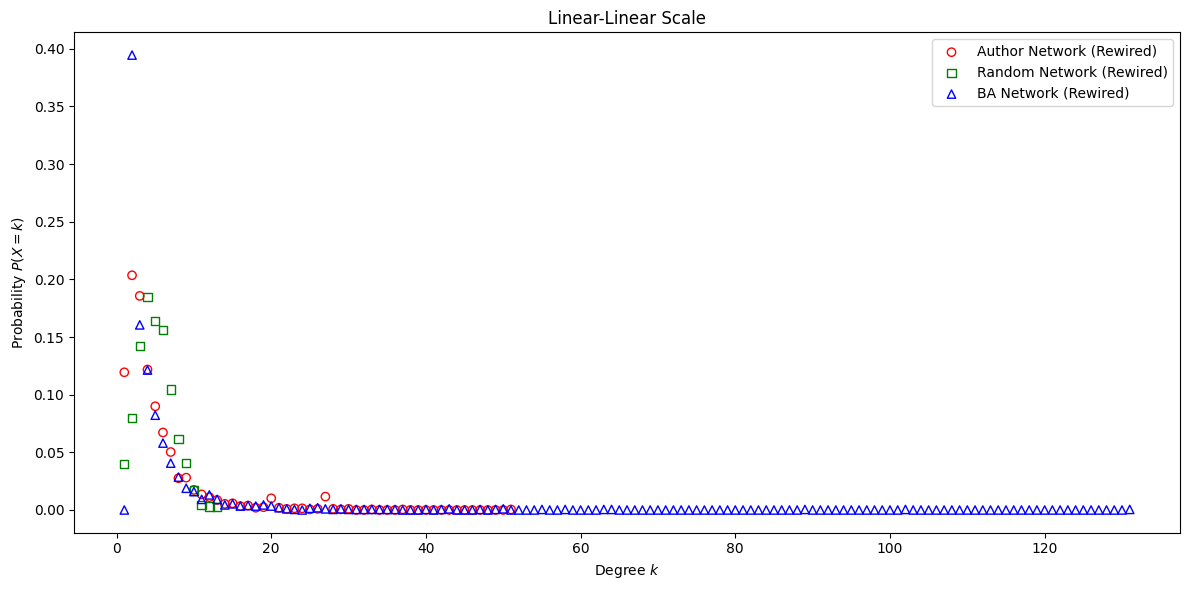

In [42]:
plot_degree_distribution_linear([author_network_rewired, random_network_rewired, BA_rewired], ['Author Network (Rewired)', 'Random Network (Rewired)', 'BA Network (Rewired)'], "degree_distributions_rewired_linear")

- Calculate the average clustering coefficient, the assortative coefficient, and the average shortest path length of the 3 networks and the 3 randomised networks; show and compare the results in a table. 

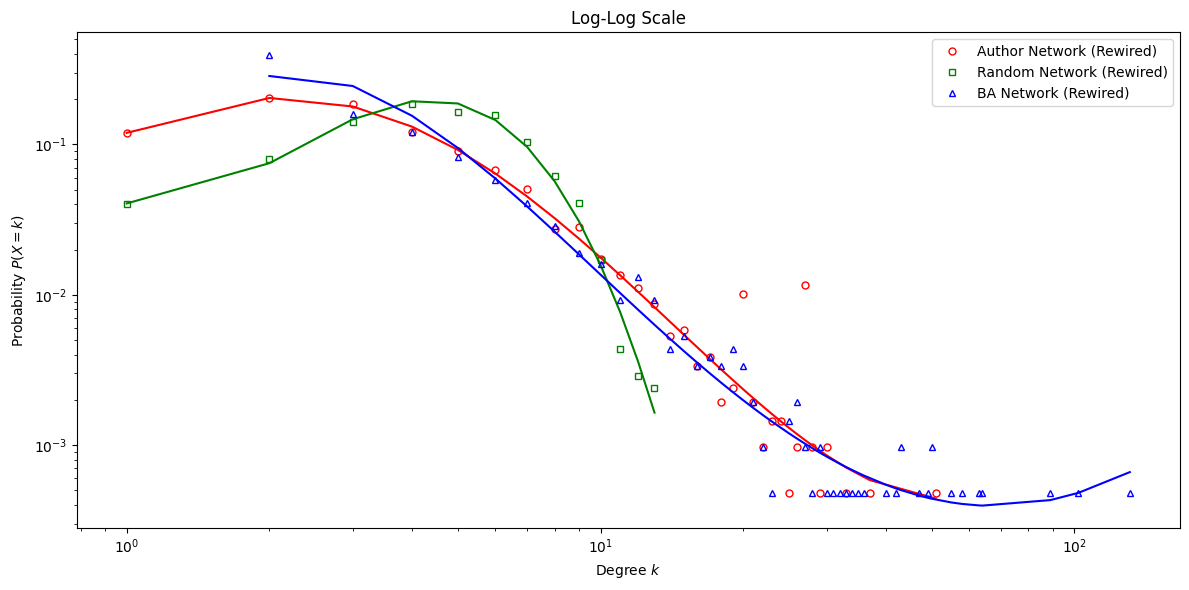

In [43]:
plot_degree_distribution_log([author_network_rewired, random_network_rewired, BA_rewired], ['Author Network (Rewired)', 'Random Network (Rewired)', 'BA Network (Rewired)'], "degree_distributions_rewired_log")

In [24]:
def compute_network_metrics(graph_name, graph):
    print(graph_name)
    graph = graph.subgraph(max(nx.connected_components(graph)))
    print(f"Giant Component Size: {round(graph.number_of_nodes(), 2)}")
    print(f"Avg Clustering Coefficient: {round(nx.algorithms.average_clustering(graph), 2)}")
    print(f"Assortative Coefficient: {round(nx.algorithms.degree_assortativity_coefficient(graph), 2)}")
    print(f"Avg Shortest Path Length: {round(nx.average_shortest_path_length(graph), 2)}")

In [48]:
compute_network_metrics("Author Network", author_network)

Author Network
Giant Component Size: 2068
Avg Clustering Coefficient: 0.62
Assortative Coefficient: 0.47
Avg Shortest Path Length: 7.3


In [26]:
compute_network_metrics("Author Network (Rewired)", author_network_rewired)

Author Network (Rewired)
Giant Component Size: 2066
Avg Clustering Coefficient: 0.01
Assortative Coefficient: -0.01
Avg Shortest Path Length: 4.42


In [50]:
compute_network_metrics("Random Network", random_network)

Random Network
Giant Component Size: 2068
Avg Clustering Coefficient: 0.0
Assortative Coefficient: 0.01
Avg Shortest Path Length: 4.94


In [27]:
compute_network_metrics("Random Network (Rewired)", random_network_rewired)

Random Network (Rewired)
Giant Component Size: 2068
Avg Clustering Coefficient: 0.0
Assortative Coefficient: -0.03
Avg Shortest Path Length: 4.95


In [52]:
compute_network_metrics("BA Network", BA)

BA Network
Giant Component Size: 2068
Avg Clustering Coefficient: 0.02
Assortative Coefficient: -0.07
Avg Shortest Path Length: 4.02


In [25]:
compute_network_metrics("BA Network (Rewired)", BA_rewired)

BA Network (Rewired)
Giant Component Size: 2068
Avg Clustering Coefficient: 0.02
Assortative Coefficient: -0.03
Avg Shortest Path Length: 4.09
